### Contents:
+ [4. Preprocessing and Modeling](#4.-Preprocessing-and-Modeling)
    - [4.1 Retrieve variables stored](#4.1-Retrieve-variables-stored)
    - [4.2 Baseline Classifier](#4.2-Baseline-Classifier)
    - [4.3 Compare Naive Bayes with Logistics Regresson](#4.3-Compare-Naive-Bayes-with-Logistics-Regresson)
    - [4.3.1 Logistics Regression with CountVectorize](#4.3.1-Logistics-Regression-with-CountVectorizer)
    - [4.3.2 Logistics Regression with TdifVectorizer](#4.3.2-Logistics-Regression-with-TdifVectorizer)
    - [4.3.3 Naive Bayes Model with CountVectorizer](#4.3.3-Naive-Bayes-Model-with-CountVectorizer)
    - [4.3.4 Naive Bayes Model with TfidfVectorizer](#4.3.4-Naive-Bayes-Model-with-TfidfVectorizer)
    - [4.3.5 Summary Table of Model Comparison](#4.3.5-Summary-Table-of-Model-Comparison)
    - [4.4 Evaluating Logistics Regression is the Chosen Classifier](#4.4-Evaluating-Logistics-Regression)
    - [4.4.1 Confusion Matrix](#4.4.1-Confusion-Matrix)
    - [4.4.2  Relationship between Sensitivity and Specificity](#4.4.2-Relationship-between-Sensitivity-and-Specificity)
    - [4.4.3 Top 10 words with the biggest impact](#4.4.3-Top-10-words-with-the-biggest-impact)

# 4. Preprocessing and Modeling

In [1]:
# Import packages.
import pandas as pd
import numpy as np
import time
from time import time
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from PIL import Image
from bs4 import BeautifulSoup
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 4.1 Retrieve variables stored

In [2]:
%store -r y_train
%store -r y_test
%store -r clean_test_posts
%store -r clean_train_posts

In [3]:
# Create a function to print out scores

def print_binary_evaluation(y_true_test, y_pred_test, y_true_train, y_pred_train):

    print("Training Data Accuracy: "+"{:.3f}".format(accuracy_score(y_true_train, y_pred_train)))
    print("Test Data Accuracy: "+"{:.3f}".format(accuracy_score(y_true_test, y_pred_test))) 
    print(f"Train/Test Accuracy Diff: "+
          "{:.3f}".format(accuracy_score(y_true_train, y_pred_train) - accuracy_score(y_true_test, y_pred_test))) 
    print(f"Test Data Recall: "+"{:.3f}".format(recall_score(y_true_test, y_pred_test)))
    print(f"Test Data Precision: "+"{:.3f}".format(precision_score(y_true_test, y_pred_test)))
    print(f"Test Data F1: "+"{:.3f}".format(f1_score(y_true_test, y_pred_test)))
    print(f"Test Data AUC ROC: "+"{:.3f}".format(roc_auc_score(y_true_test, y_pred_test)))

## 4.2 Baseline Classifier

### Baseline Classifier is DummyClassifier

In [4]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)

dummy_clf.fit(clean_train_posts, y_train)

y_pred_test_dummy = dummy_clf.predict(clean_test_posts)

y_pred_train_dummy = dummy_clf.predict(clean_train_posts)

print_binary_evaluation(y_test, y_pred_test_dummy,y_train, y_pred_train_dummy)

Training Data Accuracy: 0.508
Test Data Accuracy: 0.485
Train/Test Accuracy Diff: 0.023
Test Data Recall: 0.482
Test Data Precision: 0.492
Test Data F1: 0.487
Test Data AUC ROC: 0.485


- The accuracy value of 0.508 (training) and 0.485 (test) are low, which means the model can only classifiy a post correctly 50% (training) and 48% (test) of the times, due to either high False Positives, high False Negatives or both.

- The precision value of 0.492 is low, which means 49% of posts flagged as Android were correctly classified by this model. In other words there is a large number of False Positives.

- The recall value of 0.482 is also low, which means 48% of the actual Android posts were correctly classified by this model. In other words there is a large number of False Negatives.

- F1-Score, the harmonic mean of precision and mean, is low at 48%. 

- With the above result this is not a good model to use for classification.

## 4.3 Compare Naive Bayes with Logistics Regresson

### 4.3.1 Logistics Regression with CountVectorizer

Use Gridsearch to find best parameters

In [33]:
# Define a pipeline combining a CountVectorizer and Logistics Regression
# I use max_features of 500 to reduce overfitting

pipe_1 = Pipeline([
    ('cvec_pipe', CountVectorizer(max_features=500)),
    ('lr_pipe', LogisticRegression())
])

# Feed several parameters to Gridsearch
parameters = {
    'cvec_pipe__max_df': [0.5, 0.75],       # max document frequency
    'cvec_pipe__min_df': [2, 3],                 # min document frequency
    'cvec_pipe__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'lr_pipe__max_iter': [20,50],
    'lr_pipe__penalty': ['l1','l2'],
    'lr_pipe__C': [0.2,0.4,0.8]
    
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipe_1, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipe_1.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(clean_train_posts, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['cvec_pipe', 'lr_pipe']
parameters:
{'cvec_pipe__max_df': [0.5, 0.75],
 'cvec_pipe__min_df': [2, 3],
 'cvec_pipe__ngram_range': [(1, 1), (1, 2)],
 'lr_pipe__C': [0.2, 0.4, 0.8],
 'lr_pipe__max_iter': [20, 50],
 'lr_pipe__penalty': ['l1', 'l2']}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  6.1min finished


done in 366.758s

Best score: 0.904
Best parameters set:
	cvec_pipe__max_df: 0.5
	cvec_pipe__min_df: 3
	cvec_pipe__ngram_range: (1, 1)
	lr_pipe__C: 0.2
	lr_pipe__max_iter: 20
	lr_pipe__penalty: 'l2'


C:\Users\wtbha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Now I will use the best parameters from Gridsearch to build the vectorizer and logistic model

In [5]:
# instantiate a CountVectorizer, using best parameter settings from GridSearch 

cvec_2 = CountVectorizer(max_df=0.5,min_df=2,ngram_range=(1,1),max_features=500)
X_train_cvec_2 = cvec_2.fit_transform(clean_train_posts)
X_test_cvec_2 = cvec_2.transform(clean_test_posts)

In [6]:
# Instantiate first logistic regression model for CountVectorizer 
lr_1 = LogisticRegression(max_iter=50, solver='lbfgs',penalty='l2', C=0.4)

# Fit model to training data.
lr_1.fit(X_train_cvec_2, y_train)

# Predict based on test data
y_pred_test_cvec_lr_1 = lr_1.predict(X_test_cvec_2)

# Predict based on train data
y_pred_train_cvec_lr_1 = lr_1.predict(X_train_cvec_2)

print_binary_evaluation(y_test, y_pred_test_cvec_lr_1, y_train, y_pred_train_cvec_lr_1)

Training Data Accuracy: 0.979
Test Data Accuracy: 0.890
Train/Test Accuracy Diff: 0.089
Test Data Recall: 0.925
Test Data Precision: 0.868
Test Data F1: 0.895
Test Data AUC ROC: 0.890


#### Results show LR_1 have good accuracy and AUC ROC but the difference in accuracy between Training and Test datasets is not good enough. I will use different settings to fine-tune the model.

In [12]:
# Instantiate the 2nd logistic regression model, changing the penalty and solver
lr_2 = LogisticRegression(max_iter=20, penalty='l1',solver='liblinear',C=0.4)

# Fit model to training data.
lr_2.fit(X_train_cvec_2, y_train)

# predict based on test data
y_pred_test_cvec_lr_2 = lr_2.predict(X_test_cvec_2)

# predict based on training data
y_pred_train_cvec_lr_2 = lr_2.predict(X_train_cvec_2)

print_binary_evaluation(y_test, y_pred_test_cvec_lr_2, y_train, y_pred_train_cvec_lr_2)

Training Data Accuracy: 0.949
Test Data Accuracy: 0.893
Train/Test Accuracy Diff: 0.057
Test Data Recall: 0.970
Test Data Precision: 0.842
Test Data F1: 0.901
Test Data AUC ROC: 0.892


In [13]:
# Instantiate the 3rd logistic regression model, changing the C value
lr_3 = LogisticRegression(max_iter=20, penalty='l1',solver='liblinear', C=0.3)

# Fit model to training data.
lr_3.fit(X_train_cvec_2, y_train)

# predict based on test data
y_pred_test_cvec_lr_3 = lr_3.predict(X_test_cvec_2)

# predict based on training data
y_pred_train_cvec_lr_3 = lr_3.predict(X_train_cvec_2)

print_binary_evaluation(y_test, y_pred_test_cvec_lr_3, y_train, y_pred_train_cvec_lr_3)

Training Data Accuracy: 0.938
Test Data Accuracy: 0.890
Train/Test Accuracy Diff: 0.048
Test Data Recall: 0.970
Test Data Precision: 0.838
Test Data F1: 0.899
Test Data AUC ROC: 0.889


#### Let me try TdifVectorizer instead of CountVectorizer

An important difference between them is that CountVectorizer counts how many times a word is found in a post, whereas TFIDFVectorizer counts our words in a slightly more complicated way: in this case the vectorizer not only counts how many times a word is present in each post, but also takes into account how important the word is in the entire corpus (i.e., the collection of posts).

### 4.3.2 Logistics Regression with TdifVectorizer

Use Gridsearch to find best parameters

In [10]:
# Define a pipeline combining a TfidVectorizer and Logistics Regression
# I use max_features of 500 to reduce overfitting

pipe_2 = Pipeline([
    ('tvec_pipe', TfidfVectorizer(max_features=500)),
    ('lr_pipe', LogisticRegression())
])

# Feed several parameters to Gridsearch
parameters = {
    'tvec_pipe__max_df': [0.5, 0.75],       # max document frequency
    'tvec_pipe__min_df': [2, 3],                 # min document frequency
    'tvec_pipe__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'lr_pipe__max_iter': [20,50,100],
    'lr_pipe__penalty': ['l1','l2'],
    'lr_pipe__C': [0.2,0.4,0.8]
    
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipe_2, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipe_2.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(clean_train_posts, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tvec_pipe', 'lr_pipe']
parameters:
{'lr_pipe__C': [0.2, 0.4, 0.8],
 'lr_pipe__max_iter': [20, 50, 100],
 'lr_pipe__penalty': ['l1', 'l2'],
 'tvec_pipe__max_df': [0.5, 0.75],
 'tvec_pipe__min_df': [2, 3],
 'tvec_pipe__ngram_range': [(1, 1), (1, 2)]}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 16.9min finished


done in 1023.366s

Best score: 0.922
Best parameters set:
	lr_pipe__C: 0.8
	lr_pipe__max_iter: 20
	lr_pipe__penalty: 'l2'
	tvec_pipe__max_df: 0.75
	tvec_pipe__min_df: 3
	tvec_pipe__ngram_range: (1, 1)


C:\Users\wtbha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Now I will use the best parameters from Gridsearch to build the vectorizer and logistic model

In [7]:
# instantiate a TfidfVectorizer
tvec_1 = TfidfVectorizer(max_df=0.75,min_df=3,ngram_range=(1,1),max_features=500)

X_train_tvec_1 = tvec_1.fit_transform(clean_train_posts)
X_test_tvec_1 = tvec_1.transform(clean_test_posts)

In [8]:
# Instantiate logistic regression model.
lr_4 = LogisticRegression(max_iter=20, solver='lbfgs',penalty='l2', C=0.8)

# Fit model to training data.
lr_4.fit(X_train_tvec_1, y_train)

# Predict based on test data
y_pred_test_tvec_lr_4 = lr_4.predict(X_test_tvec_1)

# Predict based on train data
y_pred_train_tvec_lr_4 = lr_4.predict(X_train_tvec_1)

print_binary_evaluation(y_test, y_pred_test_tvec_lr_4, y_train, y_pred_train_tvec_lr_4)

Training Data Accuracy: 0.952
Test Data Accuracy: 0.895
Train/Test Accuracy Diff: 0.057
Test Data Recall: 0.920
Test Data Precision: 0.880
Test Data F1: 0.899
Test Data AUC ROC: 0.895


In [10]:
# Instantiate the 5th logistic regression model, changing penalty and solver
lr_5 = LogisticRegression(max_iter=20,penalty='l1', solver='liblinear', C=0.8)

# Fit model to training data.
lr_5.fit(X_train_tvec_1, y_train)

# predict based on test data
y_pred_test_tvec_lr_5 = lr_5.predict(X_test_tvec_1)

# predict based on test data
y_pred_train_tvec_lr_5 = lr_5.predict(X_train_tvec_1)

print_binary_evaluation(y_test, y_pred_test_tvec_lr_5, y_train, y_pred_train_tvec_lr_5)

Training Data Accuracy: 0.912
Test Data Accuracy: 0.911
Train/Test Accuracy Diff: 0.001
Test Data Recall: 0.970
Test Data Precision: 0.869
Test Data F1: 0.917
Test Data AUC ROC: 0.910


In [25]:
# Instantiate the 6th logistic regression model, changing the C value
lr_6 = LogisticRegression(max_iter=20,penalty='l1', solver='liblinear', C=0.77)

# Fit model to training data.
lr_6.fit(X_train_tvec_1, y_train)

# predict based on test data
y_pred_test_tvec_lr_6 = lr_6.predict(X_test_tvec_1)

# predict based on training data
y_pred_train_tvec_lr_6 = lr_6.predict(X_train_tvec_1)

print_binary_evaluation(y_test, y_pred_test_tvec_lr_6, y_train, y_pred_train_tvec_lr_6)

Training Data Accuracy: 0.911
Test Data Accuracy: 0.911
Train/Test Accuracy Diff: 0.000
Test Data Recall: 0.970
Test Data Precision: 0.869
Test Data F1: 0.917
Test Data AUC ROC: 0.910


### 4.3.3 Naive Bayes Model with CountVectorizer

There are 3 subtypes
- MultinomialNB
- BernoulliNB
- GaussianNB

Bernoulli is suitable for binary data whereas Multinomial is able to handle non-binary numbers. I have checked during EDA that the data is not binary so I will be using Multinomial.

In [15]:
# Define a pipeline combining a CountVectorizer and Logistics Regression
# I use max_features of 500 to reduce overfitting

pipe_3 = Pipeline([
    ('cvec_pipe', CountVectorizer(max_features=500)),
    ('nb_pipe', MultinomialNB())
])

# Feed several parameters to Gridsearch
parameters = {
    'cvec_pipe__max_df': [0.5, 0.75],       # max document frequency
    'cvec_pipe__min_df': [2, 3],                 # min document frequency
    'cvec_pipe__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'nb_pipe__alpha': [0,0.5,1]
    
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipe_3, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipe_3.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(clean_train_posts, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['cvec_pipe', 'nb_pipe']
parameters:
{'cvec_pipe__max_df': [0.5, 0.75],
 'cvec_pipe__min_df': [2, 3],
 'cvec_pipe__ngram_range': [(1, 1), (1, 2)],
 'nb_pipe__alpha': [0, 0.5, 1]}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.6min finished


done in 160.640s

Best score: 0.918
Best parameters set:
	cvec_pipe__max_df: 0.75
	cvec_pipe__min_df: 2
	cvec_pipe__ngram_range: (1, 2)
	nb_pipe__alpha: 0


C:\Users\wtbha\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


#### Use the GridSerch result to create a CountVectorizer and MultinomialNB

In [12]:
# instantiate a CountVectorizer 

cvec_3 = CountVectorizer(max_df=0.75,min_df=2,ngram_range=(1,2),max_features=500)
X_train_cvec_3 = cvec_3.fit_transform(clean_train_posts)
X_test_cvec_3 = cvec_3.transform(clean_test_posts)

In [13]:
# Instantiate a Multinomial Naive Bayes model
nb_1 = MultinomialNB(alpha=0)

# Fit our model
nb_1.fit(X_train_cvec_3, y_train)

# predict with train data
y_pred_train_cvec_nb_1 = nb_1.predict(X_train_cvec_3)

# predict with test data
y_pred_test_cvec_nb_1 = nb_1.predict(X_test_cvec_3)

# Show summary scores
print_binary_evaluation(y_test, y_pred_test_cvec_nb_1, y_train, y_pred_train_cvec_nb_1)

Training Data Accuracy: 0.924
Test Data Accuracy: 0.878
Train/Test Accuracy Diff: 0.046
Test Data Recall: 0.874
Test Data Precision: 0.883
Test Data F1: 0.879
Test Data AUC ROC: 0.878


C:\Users\wtbha\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [14]:
# Instantiate a model and change alpha to 0.5
nb_2 = MultinomialNB(alpha=0.5)

# Fit our model
nb_2.fit(X_train_cvec_3, y_train)

# predict with train data
y_pred_train_cvec_nb_2 = nb_2.predict(X_train_cvec_3)

# predict with test data
y_pred_test_cvec_nb_2 = nb_2.predict(X_test_cvec_3)

# Show summary scores
print_binary_evaluation(y_test, y_pred_test_cvec_nb_2, y_train, y_pred_train_cvec_nb_2)

Training Data Accuracy: 0.921
Test Data Accuracy: 0.875
Train/Test Accuracy Diff: 0.046
Test Data Recall: 0.869
Test Data Precision: 0.883
Test Data F1: 0.876
Test Data AUC ROC: 0.875


### 4.3.4 Naive Bayes Model with TfidfVectorizer

In [19]:
# Define a pipeline combining a TfidVectorizer and MultinomialNB classifier
# I use max_features of 500 to reduce overfitting

pipe_4 = Pipeline([
    ('tvec_pipe', TfidfVectorizer(max_features=500)),
    ('nb_pipe', MultinomialNB())
])

# Feed several parameters to Gridsearch
parameters = {
    'tvec_pipe__max_df': [0.5, 0.75],       # max document frequency
    'tvec_pipe__min_df': [2, 3],                 # min document frequency
    'tvec_pipe__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'nb_pipe__alpha': [0,0.5,1]
    
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipe_4, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipe_4.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(clean_train_posts, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tvec_pipe', 'nb_pipe']
parameters:
{'nb_pipe__alpha': [0, 0.5, 1],
 'tvec_pipe__max_df': [0.5, 0.75],
 'tvec_pipe__min_df': [2, 3],
 'tvec_pipe__ngram_range': [(1, 1), (1, 2)]}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.2min finished


done in 201.705s

Best score: 0.904
Best parameters set:
	nb_pipe__alpha: 1
	tvec_pipe__max_df: 0.5
	tvec_pipe__min_df: 3
	tvec_pipe__ngram_range: (1, 2)


In [15]:
# instantiate a TfidfVectorizer
tvec_2 = TfidfVectorizer(max_df=0.5,min_df=3,ngram_range=(1,2),max_features=500)

X_train_tvec_2 = tvec_2.fit_transform(clean_train_posts)
X_test_tvec_2 = tvec_2.transform(clean_test_posts)

In [16]:
# Instantiate a Multinomial Naive Bayes model
nb_3 = MultinomialNB(alpha=1)

# Fit our model
nb_3.fit(X_train_tvec_2, y_train)

# predict with train data
y_pred_train_cvec_nb_3 = nb_3.predict(X_train_tvec_2)

# predict with test data
y_pred_test_cvec_nb_3 = nb_3.predict(X_test_cvec_2)

# Show summary scores
print_binary_evaluation(y_test, y_pred_test_cvec_nb_3, y_train, y_pred_train_cvec_nb_3)

Training Data Accuracy: 0.918
Test Data Accuracy: 0.691
Train/Test Accuracy Diff: 0.227
Test Data Recall: 0.588
Test Data Precision: 0.750
Test Data F1: 0.659
Test Data AUC ROC: 0.693


In [17]:
# Instantiate another model with a different alpha
nb_4 = MultinomialNB(alpha=0.5)

# Fit our model
nb_4.fit(X_train_tvec_2, y_train)

# predict with train data
y_pred_train_tvec_nb_4 = nb_4.predict(X_train_tvec_2)

# predict with test data
y_pred_test_tvec_nb_4 = nb_4.predict(X_test_tvec_2)

# Show summary scores
print_binary_evaluation(y_test, y_pred_test_tvec_nb_4, y_train, y_pred_train_tvec_nb_4)

Training Data Accuracy: 0.919
Test Data Accuracy: 0.847
Train/Test Accuracy Diff: 0.072
Test Data Recall: 0.849
Test Data Precision: 0.849
Test Data F1: 0.849
Test Data AUC ROC: 0.847


### 4.3.5 Summary Table of Model Comparison

<h3 align=center>Summary Table of comparison</h3>
<h5 align=center>Note: Values are rounded to 3 decimal places through codes, so some may appear inaccurate</h5>

|Model|Train Accuracy|Test Accuracy|Train/Test Accuracy Diff|Recall|Precision|F1 Score|AUC-ROC|
|---|---|---|---|---|---|---|---|
|Baseline DummyClassifier|0.508|0.485|0.023|0.482|0.492|0.487|0.485|
|Logistic 1 with CountVect (penalty='l2',solver='lbfgs',C=0.4)|0.977|0.890|0.089|0.925|0.868|0.895|0.890|
|Logistic 2 with CountVect (penalty='l1',solver='liblinear',C=0.4)|0.940|0.893|0.057|0.970|0.842|0.901|0.892|
|Logistic 3 with CountVect (penalty='l1',solver='liblinear',C=0.3)|0.938|0.890|0.048|0.970|0.838|0.899|0.899|
|Logistic 4 with TfidfVect (penalty='l2',solver='lbfgs',C=0.8)|0.952|0.895|0.057|0.920|0.880|0.899|0.895|
|Logistic 5 with TfidfVect (penalty='l1',solver='liblinear',C=0.8)|0.912|0.911|0.01|0.970|0.869|0.917|0.910|
|<font color=blue><b>Logistic 6 with TfidfVect (penalty='l1',solver='liblinear',C=0.77)</b></font>|<font color=blue><b>0.911</b></font>|<font color=blue><b>0.911</b></font>|<font color=blue><b>0.000</b></font>|<font color=blue><b>0.970</b></font>|<font color=blue><b>0.869</b></font>|<font color=blue><b>0.917</b></font>|<font color=blue><b>0.910</b></font>|
|Multinomial 1 with CountVect (alpha=0)|0.924|0.878|0.046|0.874|0.883|0.879|0.878|
|Multinomial 2 with CountVect (alpha=0.5)|0.921|0.875|0.046|0.869|0.883|0.876|0.875|
|Multinomial 3 with TfidfVect (alpha=1)|0.918|0.691|0.227|0.588|0.750|0.659|0.693|
|Multinomial 4 with TfidfVect (alpha=0.5)|0.919|0.847|0.072|0.849|0.849|0.849|0.847|


#### 1) In general all logistic and Multinomial models have vast improvement over the baseline model.

#### 2) Logistic Regression 6th (blue text) models is the best model for the following reasons:

- High Accuracy
<br />The model is able to classifiy a post correctly 91% of the time
- Perfect fit (no overfit or underfit)
<br />This means it will be able to handle unseen data very well
- High F1 Score
<br />It means there are very low false positives and low false negatives. In other words, there is very low chance of incorrect classification
- High AUC-ROC
<br />It means the model is very capable of distinguishing between classes

## 4.4 Evaluating Logistics Regression


### 4.4.1 Confusion Matrix

- A true positive is a post that is predicted to come from the Android subreddit and really is from the Android subreddit.
- A true negative is a post that is predicted to come from the iPhone subreddit and really is from the iPhone subreddit.
- A false positive is a post that is predicted to come from the Android subreddit but actually comes from the iPhone subreddit.
- A false negative is a post that is predicted to come from the iPhone subreddit but actually comes from Android subreddit.

In [26]:
# Get the confusion matrix from Logistic number 6 with TfidfVectorizer
cm = confusion_matrix(y_test,y_pred_test_tvec_lr_6)

# Create a dataframe for displaying the result properly
cm_df = pd.DataFrame(cm, columns=['pred Android', 'pred iPhone'], index=['actual Android', 'actual iPhone'])
cm_df

,pred Android,pred iPhone
actual Android,164,29
actual iPhone,6,193


In [27]:
# Flatten the matrix to retrieve True Negative (tn), False Positive (fp), False Negative (fn) and True Positive (tp)
tn, fp, fn, tp = cm.ravel() 

# create a dataframe for displaying the result properly
d = {'Metric': ['True Negatives', 'False Positives', 'False Negatives', 'True Positives',
     'Accuracy',' Misclassification Rate', 'True Positive Rate/sensitivity/recall',
     'Precision','False Positive Rate','False Negative Rate'],           
     'Value': ['%.3f'%tn,'%.3f'%fp,'%.3f'%fn,'%.3f'%tp,'%.3f'%((tp+tn)/(tp+tn+fp+fn)),'%.3f'%((fp+fn)/(tp+tn+fp+fn)),
               '%.3f'%(tp/(tp+fn)),'%.3f'%(tp/(tp+fp)),'%.3f'%(fp/(fp+tn)),'%.3f'%(fn/(fn+tp))]}
pd.DataFrame(data=d)

,Metric,Value
0,True Negatives,164.000
1,False Positives,29.000
2,False Negatives,6.000
3,True Positives,193.000
4,Accuracy,0.911
5,Misclassification Rate,0.089
6,True Positive Rate/sensitivity/recall,0.970
7,Precision,0.869
8,False Positive Rate,0.150
9,False Negative Rate,0.030


#### The confusion matrix shows True Negatives and True Positives are much higher than False Negatives and False Positives, which means the model has very good performance in identifying the correct Android and iPhone posts.

### 4.4.2 Relationship between Sensitivity and Specificity

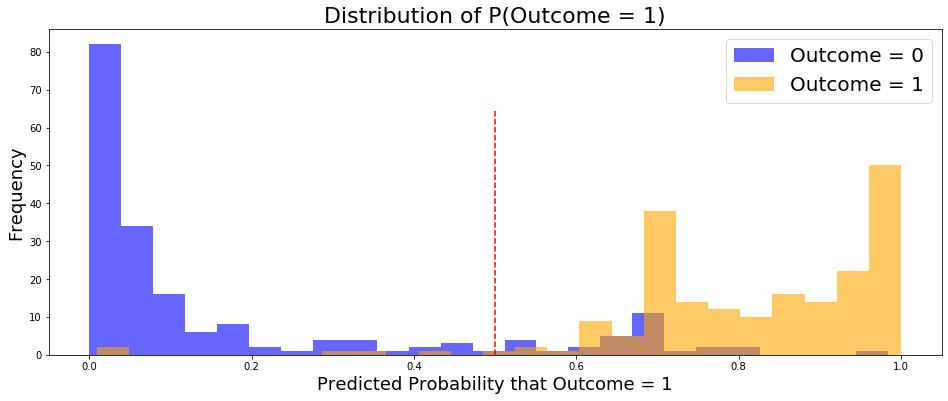

In [28]:
# Create a dataframe that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our Logistic Model number 6


pred_proba_1 = [i[1] for i in lr_6.predict_proba(X_test_tvec_1)]
pred_df_1 = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_1})

# Create figure.
plt.figure(figsize = (16,6))

# Create two histograms of observations.
plt.hist(pred_df_1[pred_df_1['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df_1[pred_df_1['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

The above plot is divded into two halves by a vertical red line. Those on right side of the red line are Actual Android Posts  and those on the left are Actual iPhone Posts.

The bars are the predictions - Orange bars represent the posts predicted as Android, Blue bars to represent the posts predicted as iPhone.

We can see the orange bars are mostly on the right and blue bars are mostly on the left, which mean the predictions are mostly correct. 

We can see very little overlaps - orange bars appear on the left and blue bars appear on the right, which False Negatives and False Positives respectively

The overlaps refer to incorrect predictions, and the plot shows it has very little, which means the model has largely done the correct predictions. 

### 4.4.3 Top 10 words with the biggest impact

In [30]:
# Retrieve coefficients and features
coef_names = tvec_1.get_feature_names()

# Create a dataframe to hold coefficients and features
coef_df = pd.DataFrame ({
    'coefs' : coef_names,
    'values' : lr_6.coef_[0]
}).set_index('coefs')

# Display the top 10 wors in descending order
coef_df.reindex(coef_df['values'].abs().sort_values(ascending=False).index)[:10]

,values
coefs,
iphone,-33.160025
android,14.117177
samsung,8.187749
galaxy,7.261174
ios,-6.518604
apple,-5.391417
icloud,-5.251393
safari,-4.818363
root,4.000311


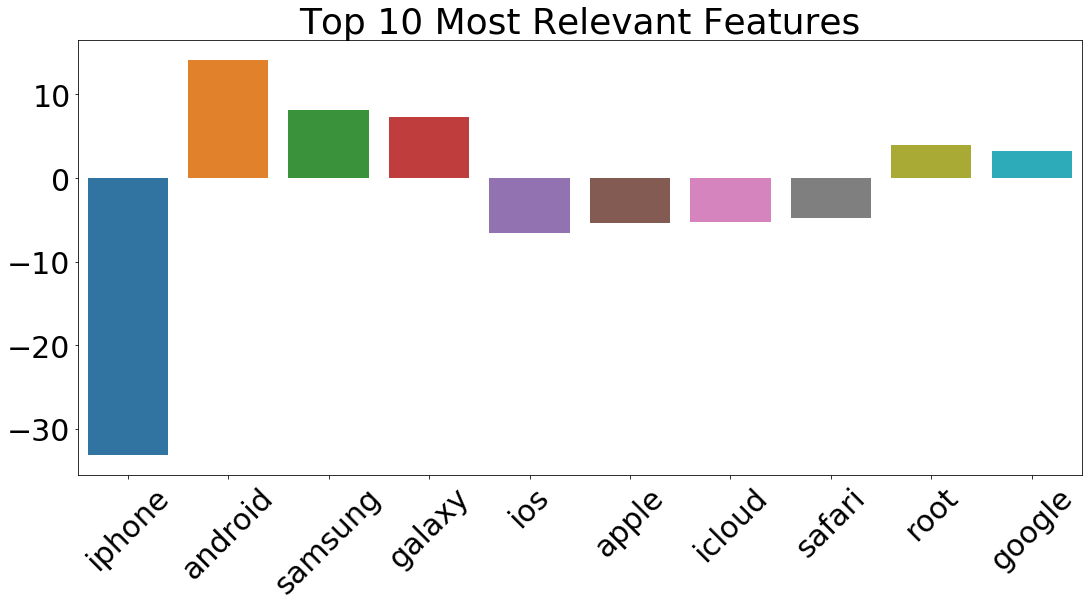

In [32]:
# Visualize the top relevant words
fig = plt.figure(figsize=(18,8))

# Get the names and values of the top 10 words with highest influence on classification
words=coef_df.reindex(coef_df['values'].abs().sort_values(ascending=False).index)[:10].index.values.tolist()
counts=coef_df.reindex(coef_df['values'].abs().sort_values(ascending=False).index)[:10]['values'].tolist()

# Display the result with bar charts
bar_plot = sns.barplot(x=words, y=counts)
plt.rcParams.update({'font.size':30})
for item in bar_plot.get_xticklabels():
    item.set_rotation(45)
plt.title('Top 10 Most Relevant Features')
plt.show()

#### The above plot shows how important each feature is in classifying a post

- The model has done a very good job in its feature selection function, giving us the top 10 keywards that are very relevant to Android and iPhone

- It is not surprising that the words "iPhone" and "Android" came out at the very top. 

- At second position, "Android" considered is less relevant than "iPhone" because there are many Android hardware manufacturers and people usually refer to their phones by the hardware manufacturers, such as Samsung, which incidentally is at 3rd position. 

- Technically speaking Android is the operating system of the phone, and its equivalence for iPhone is known as "ios", which also came out top at 5th position. 

- Hardware manufacturers refer to their phones by product or model names, such as Galaxy by Samsung, which is at 4th position

- At number 6 and 10 are Apple and Google, the companies behind iPhone and Android respectively

- Apple's other products in the top 10 are ios, icloud (cloud storage and computing solution) and safari (browser). The latest major release for ios is 13, which is at 5th position, while iCloud is at 7th and safari at number 8